In [130]:
# dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nfx.glm.poisson
import nfx.glm.gaussian
import nfx.misc.plot

sns.set()
plt.rcParams.update({   
          "text.usetex" : True,
          "pgf.texsystem": 'pdflatex',
          "font.size": 8,
          "font.family" : "serif"})

In [45]:
# helper functions

def package_samples(samples, node_names, covariate_names, meta):

    coef_samples, prec_samples = zip(*samples)
    coef_samples = [np.array(coef_samples_) for coef_samples_ in zip(*coef_samples)][::-1]
    prec_samples = np.trace(prec_samples, axis1=2, axis2=3).T[::-1]
    return package_coef_samples(coef_samples, node_names, covariate_names, meta), package_prec_samples(prec_samples, meta)

def package_coef_samples(coef_samples, node_names, covariate_names, meta):

    dfs = []
    for i, (coef_samples_, node_names_) in enumerate(zip(coef_samples, node_names)):
        for j, node_names__ in enumerate(node_names_):
            df_ = pd.DataFrame(coef_samples_[:, j].T, index=covariate_names)
            df_.index = df_.index.rename('covariate')
            df_.columns = df_.columns.rename('iter')
            for k, v in meta.items():
                df_[k] = v
            df_['level'] = i
            df_['node'] = node_names__.zfill(i + 1)
            dfs.append(df_)
    df = pd.concat(dfs).reset_index().set_index(['level', 'node', 'covariate'] + list(meta.keys()))
    return df

def package_prec_samples(prec_samples, meta):

    df = pd.DataFrame(prec_samples, index=np.arange(len(prec_samples)))
    df.index = df.index.rename('level')
    df.columns = df.columns.rename('iter')
    for k, v in meta.items():
        df[k] = v
    df = df.reset_index().set_index(['level'] + list(meta.keys()))
    return df

def est_acf(samples, n_lags):

    acf = samples.apply(lambda x: nfx.misc.plot.est_acf(x.values, n_lags), 1, False, 'expand')
    acf.columns = acf.columns.rename('lag')
    return acf

def est_ess(acfs, titer):
    
    df = pd.DataFrame(index=acfs.index)
    df['iat[iter]'] = acfs.apply(lambda x: nfx.misc.plot.est_int_autocor(x.values), 1, False, 'expand').rename('iat')
    df['iat[sec]'] = df['iat[iter]'] * titer
    df['rate[iter]'] = 1 / (2 * df['iat[iter]'])
    df['rate[sec]'] = df['rate[iter]'] / titer
    return df

In [46]:
# config

covariate_names = ['housing']
n_samples = 10000
n_warmup = 1000
seed = 0

In [47]:
# load data

macro = pd.read_csv('demos/data/sareb_covariates.csv').set_index('time')
nobs = pd.read_csv('demos/data/sareb_nobs_synthetic.csv').set_index('zip')
rng = np.random.default_rng(seed)

In [48]:
# format response

response = nobs.dropna(axis=1)
response.head()

,2007-03-31,2007-06-30,2007-09-30,2007-12-31,2008-03-31,2008-06-30,2008-09-30,2008-12-31,2009-03-31,2009-06-30,...,2015-12-31,2016-03-31,2016-06-30,2016-09-30,2016-12-31,2017-03-31,2017-06-30,2017-09-30,2017-12-31,2018-03-31
zip,,,,,,,,,,,,,,,,,,,,,
01002,428,249,154,163,62,181,172,22,20,18,...,32,31,43,28,43,53,69,31,74,43
01003,54,49,16,36,144,59,142,206,41,19,...,61,48,101,37,86,73,61,79,43,71
01006,29,26,14,7,19,10,3,25,110,11,...,31,35,43,29,50,29,45,69,29,39
0100x,156,117,174,92,172,137,183,88,96,74,...,124,65,133,100,87,185,154,147,176,142
01010,98,76,50,72,36,54,38,71,29,60,...,47,52,80,58,78,87,87,68,99,254


In [49]:
# format covariates

covariates = macro.loc[:, covariate_names]
covariates['_constant'] = 1
covariates['_trend'] = np.arange(covariates.shape[0])
covariates = covariates.loc[:, ['_constant', '_trend', 'housing']].dropna().loc[response.columns]
covariates.head()

,_constant,_trend,housing
2007-03-31,1,0,0.000000
2007-06-30,1,1,0.028160
2007-09-30,1,2,0.038869
2007-12-31,1,3,0.031732
2008-03-31,1,4,0.028020


In [50]:
# construct tree

indices = response.index.to_frame()
indices['lvl_1'] = indices.zip.str.slice(0, 2)
indices['lvl_2'] = indices.zip.str.slice(0, 3)
indices['lvl_3'] = indices.zip.str.slice(0, 4)
indices['lvl_4'] = indices.zip.str.slice(0, 5)
indices = indices.drop('zip', axis=1)
codes = indices.apply(lambda x: x.astype('category').cat.codes).astype('int64')
n_nodes = codes.max(0) + 1
parent_node_3 = codes[['lvl_4', 'lvl_3']].drop_duplicates().lvl_3
parent_node_2 = codes[['lvl_3', 'lvl_2']].drop_duplicates().lvl_2
parent_node_1 = codes[['lvl_2', 'lvl_1']].drop_duplicates().lvl_1
node_names = [['0'], indices.lvl_1.unique(), indices.lvl_2.unique(), indices.lvl_3.unique(), indices.lvl_4.unique()]
tree = [parent_node_3.values, parent_node_2.values, parent_node_1.values]

In [51]:
# sample from posterior. some warnings will appear during warmup

sampler = nfx.glm.poisson.sample_posterior(response.values, np.ones_like(response.values), covariates.values, tree, ome=rng)
samples = [next(sampler) for _ in range(n_warmup + n_samples)][n_warmup:]

/Users/tim.sf/Documents/research/hierarch/nfx_remote/nfx/glm/metropolis.py:112: RuntimeWarning: invalid value encountered in sqrt
  mah = np.sum(np.square(((x - mu) @ u) * np.sqrt(l_tau)), 1)
/Users/tim.sf/Documents/research/hierarch/nfx_remote/nfx/glm/metropolis.py:113: RuntimeWarning: invalid value encountered in log
  return (np.sum(np.log(l_tau), 1) - mah - x.shape[1] * np.log(2 * np.pi)) / 2


In [52]:
# compute sla summaries

coef_samples, prec_samples = package_samples(samples, node_names, ['_const', '_trend'] + covariate_names, {'algo_name': 'SLA'})
coef_acf, prec_acf = (est_acf(samples_, 256) for samples_ in (coef_samples, prec_samples))
coef_ess, prec_ess = (est_ess(acfs_, 1) for acfs_ in (coef_acf, prec_acf))

/Users/tim.sf/Library/Caches/pypoetry/virtualenvs/nfx-remote-J5Ks3VFH-py3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


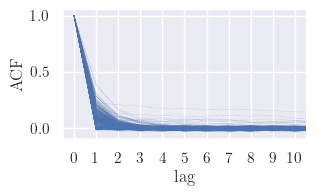

In [131]:
acf = pd.concat([coef_acf.reset_index(), prec_acf.reset_index()]).set_index(['algo_name', 'level', 'node', 'covariate'])
iat = acf.apply(lambda x: nfx.misc.plot.est_int_autocor(x.values), 1, False, 'expand').rename('iat')
rank = iat.rank(ascending=False)
#acf = acf.loc[(acf.columns.astype(float) < 10) | (acf.columns.astype(float) % 10 == 0)].reset_index()
acf = acf.loc[(rank < 20) | (rank % 20 == 0)].reset_index()
acf['param_ix'] = acf.index
acf_long = acf.melt(id_vars=['algo_name', 'level', 'node', 'covariate', 'param_ix'], var_name='lag').dropna(subset=['value'])
acf_long['type'] = acf_long.node.isna()

g = sns.relplot(data=acf_long, x='lag', y='value', kind='line', style='param_ix', legend=False, height=2, aspect=8/5, alpha=1/3, lw=1/3)
g.set(xlabel='lag', ylabel='ACF', xlim=(-.5, 10.5), xticks=np.arange(0, 11))
g.set_titles(col_template='{col_name}')

plt.savefig('/Users/tim.sf/Documents/research/hierarch/paper_ejs_revision2/figs/nested_poisson_sareb.pdf', backend='pgf', bbox_inches='tight')

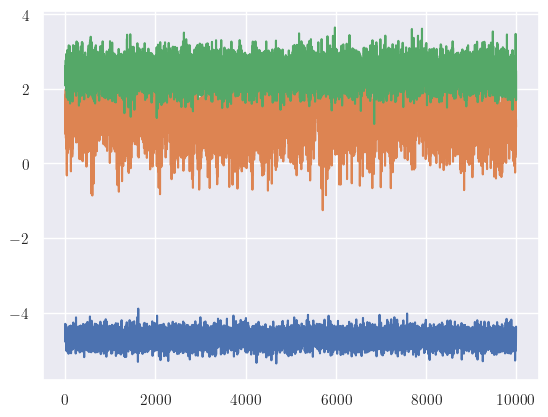

In [192]:
plt.plot(coef_samples.loc[4, '28760', 'housing', 'SLA'])
plt.plot(coef_samples.loc[3, '2876', 'housing', 'SLA'])
plt.plot(coef_samples.loc[2, '287', 'housing', 'SLA'])

In [246]:
# sample from posterior. some warnings will appear during warmup

import importlib; importlib.reload(nfx.glm.poisson); importlib.reload(nfx.glm.poisson.gibbs)
sampler2 = nfx.glm.poisson.sample_posterior(response.values, np.ones_like(response.values), covariates.values, tree, init=samples[-1], ome=rng)
samples2 = [next(sampler2) for _ in range(2000)][n_warmup:]

In [247]:
# compute sla summaries

coef_samples, prec_samples = package_samples(samples2, node_names, ['_const', '_trend'] + covariate_names, {'algo_name': 'SLA'})
coef_acf, prec_acf = (est_acf(samples_, 256) for samples_ in (coef_samples, prec_samples))
coef_ess, prec_ess = (est_ess(acfs_, 1) for acfs_ in (coef_acf, prec_acf))

In [248]:
coef_ess.max()

iat[iter]     1.490798
iat[sec]      1.490798
rate[iter]    1.863963
rate[sec]     1.863963
dtype: float64